<a href="https://colab.research.google.com/github/dophison/NT131.N21/blob/main/LSTMforAgricultureUITlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
from urllib.parse import quote
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [15]:
url = "http://103.200.22.212:60000/query?sql=SELECT * FROM sensorParser"
encoded_url = quote(url, safe=':/?=&')

In [19]:
response = requests.get(encoded_url)
data = response.json()
#sử dụng thư viện requests để thực hiện yêu cầu HTTP và lấy dữ liệu từ URL đó. 
#Sau đó, chuyển đổi dữ liệu từ định dạng JSON thành mảng dữ liệu Python
df = pd.DataFrame(data)

In [20]:
df

,id,id_wasp,id_secret,frame_type,frame_number,sensor,value,timestamp,sync,raw,parser_type,MeshliumID
0,21,SAP_NHOM15,48581CE819623C8B,134,0,PRES,100736.93,2023-05-25T19:20:25.000Z,0,noraw,1,20274081525527
1,22,SAP_NHOM15,48581CE819623C8B,134,0,HUM,55.5,2023-05-25T19:20:25.000Z,0,noraw,1,20274081525527
2,23,SAP_NHOM15,48581CE819623C8B,134,0,TC,24.53,2023-05-25T19:20:25.000Z,0,noraw,1,20274081525527
3,24,SAP_NHOM15,48581CE819623C8B,134,0,BAT,15,2023-05-25T19:20:25.000Z,0,noraw,1,20274081525527
4,25,SAP_NHOM15,48581CE819623C8B,134,0,STR,new_sensor_frame,2023-05-25T19:20:25.000Z,0,noraw,1,20274081525527
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,1270,SAP_NHOM15,48581CE819623C8B,134,5,PRES,100709.67,2023-05-25T19:58:01.000Z,0,noraw,1,20274081525527
1201,1271,SAP_NHOM15,48581CE819623C8B,134,5,HUM,56.2,2023-05-25T19:58:01.000Z,0,noraw,1,20274081525527
1202,1272,SAP_NHOM15,48581CE819623C8B,134,5,TC,24.54,2023-05-25T19:58:01.000Z,0,noraw,1,20274081525527
1203,1273,SAP_NHOM15,48581CE819623C8B,134,5,BAT,19,2023-05-25T19:58:01.000Z,0,noraw,1,20274081525527


In [22]:
cols_to_keep = ['sensor', 'value', 'timestamp']  # Các cột chỉ định giữ lại

df = df[cols_to_keep]  # Giữ lại các cột chỉ định

df.head(100)

,sensor,value,timestamp
0,PRES,100736.93,2023-05-25T19:20:25.000Z
1,HUM,55.5,2023-05-25T19:20:25.000Z
2,TC,24.53,2023-05-25T19:20:25.000Z
3,BAT,15,2023-05-25T19:20:25.000Z
4,STR,new_sensor_frame,2023-05-25T19:20:25.000Z
...,...,...,...
95,PRES,100744.22,2023-05-25T19:14:29.000Z
96,HUM,55.1,2023-05-25T19:14:29.000Z
97,TC,24.78,2023-05-25T19:14:29.000Z
98,BAT,14,2023-05-25T19:14:29.000Z


In [23]:
df = df[~df['sensor'].isin(['BAT', 'STR'])]
#Bỏ các hàng trong df mà cột "sensor" có giá trị là BAT hoặc STR. 
#"~" lấy các hàng không thoả điều kiện này
df.head(10)

,sensor,value,timestamp
0,PRES,100736.93,2023-05-25T19:20:25.000Z
1,HUM,55.5,2023-05-25T19:20:25.000Z
2,TC,24.53,2023-05-25T19:20:25.000Z
5,PRES,100740.69,2023-05-25T19:20:05.000Z
6,HUM,55.1,2023-05-25T19:20:05.000Z
7,TC,24.52,2023-05-25T19:20:05.000Z
10,PRES,100735.05,2023-05-25T19:19:42.000Z
11,HUM,55.1,2023-05-25T19:19:42.000Z
12,TC,24.54,2023-05-25T19:19:42.000Z
15,PRES,100737.53,2023-05-25T19:19:25.000Z


In [24]:
# Tách thành các thuộc tính mới A, B, C
df_new = df.pivot(index='timestamp', columns='sensor', values='value')
df_new = df_new.sort_values(by='timestamp').reset_index()

In [27]:
df_new.head(100)

sensor,timestamp,HUM,PRES,TC
0,2023-05-18T20:05:38.000Z,57.1,100587.03,24.49
1,2023-05-18T20:06:01.000Z,57.3,100582.67,24.47
2,2023-05-18T20:06:18.000Z,57.2,100583.13,24.46
3,2023-05-18T20:06:35.000Z,57.1,100586.05,24.44
4,2023-05-18T20:06:52.000Z,57.1,100581.08,24.41
...,...,...,...,...
95,2023-05-25T19:12:37.000Z,53.7,100736.06,25.09
96,2023-05-25T19:12:59.000Z,53.7,100741.52,25.03
97,2023-05-25T19:13:16.000Z,53.9,100745.11,24.97
98,2023-05-25T19:13:33.000Z,54.2,100751.39,24.92


In [73]:
tempa = df_new[['TC']].values

In [74]:
tempa

array([['24.49'],
       ['24.47'],
       ['24.46'],
       ['24.44'],
       ['24.41'],
       ['24.37'],
       ['24.33'],
       ['24.30'],
       ['24.25'],
       ['24.24'],
       ['24.24'],
       ['24.25'],
       ['24.27'],
       ['24.31'],
       ['24.35'],
       ['24.90'],
       ['24.91'],
       ['24.92'],
       ['24.92'],
       ['24.93'],
       ['24.93'],
       ['24.94'],
       ['24.94'],
       ['24.95'],
       ['24.96'],
       ['24.98'],
       ['25.01'],
       ['25.03'],
       ['25.04'],
       ['25.04'],
       ['25.02'],
       ['25.01'],
       ['24.99'],
       ['24.98'],
       ['24.97'],
       ['24.98'],
       ['24.96'],
       ['24.97'],
       ['24.97'],
       ['24.97'],
       ['25.01'],
       ['25.04'],
       ['25.10'],
       ['25.11'],
       ['25.12'],
       ['25.10'],
       ['25.06'],
       ['24.99'],
       ['24.93'],
       ['24.88'],
       ['24.84'],
       ['24.80'],
       ['24.75'],
       ['24.70'],
       ['24.68'],
       ['2

In [94]:
#temparature
tempa = df_new[['TC']].values
# Normalize the input variables
scaler = MinMaxScaler()
tempa_scaled = scaler.fit_transform(tempa)

#humid
humid = df_new[['HUM']].values
# Normalize the input variables
scaler_1 = MinMaxScaler()
humid_scaled = scaler_1.fit_transform(humid)

#pressure
pres = df_new[['PRES']].values
# Normalize the input variables
scaler_2 = MinMaxScaler()
pres_scaled = scaler_2.fit_transform(pres)



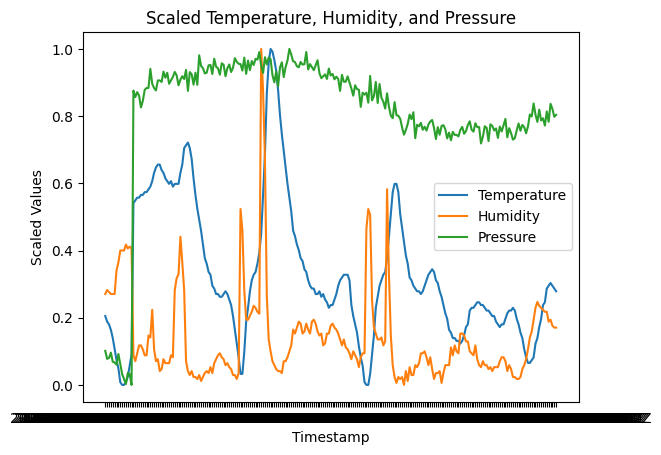

In [101]:
timestamps = df_new['timestamp']

# Vẽ biểu đồ đường cho biến tempa
plt.plot(timestamps, tempa_scaled, label='Temperature')

# Vẽ biểu đồ đường cho biến humid
plt.plot(timestamps, humid_scaled, label='Humidity')

# Vẽ biểu đồ đường cho biến pres
plt.plot(timestamps, pres_scaled, label='Pressure')

# Đặt tiêu đề và nhãn cho trục x, y
plt.title('Scaled Temperature, Humidity, and Pressure')
plt.xlabel('Timestamp')
plt.ylabel('Scaled Values')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

In [102]:
#Split data 70% data train, 30% data test
tempa_train, tempa_test = train_test_split(tempa_scaled, test_size=0.3, random_state=1)
humid_train, humid_test = train_test_split(humid_scaled, test_size=0.3, random_state=1)
pres_train, pres_test = train_test_split(pres_scaled, test_size=0.3, random_state=1)

In [132]:
#Hàm LSTM forecast
def lstm_forecast(train_scaled, test_scaled, scaler):
  train_scaled = train_scaled.reshape((train_scaled.shape[0], 1, train_scaled.shape[1]))
  test_scaled = test_scaled.reshape((test_scaled.shape[0], 1, test_scaled.shape[1]))
# Define the LSTM model
  model = Sequential()
  model.add(LSTM(2, input_shape=(1, train_scaled.shape[2])))
  model.add(Dense(1))
# Compile the model
  model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
  model.fit(train_scaled, train_scaled, epochs=20, batch_size=32, verbose=0)

# Make predictions on the test data
  predictions = model.predict(test_scaled)

# Inverse transform the predictions to their original scale
  predictions_rescaled = scaler.inverse_transform(predictions)
  return predictions_rescaled, train_scaled, test_scaled

In [136]:
predictions_rescaled_TC, tempa_train, tempa_test = lstm_forecast(tempa_train, tempa_test, scaler)
predictions_rescaled_Hum, humid_train, humid_test = lstm_forecast(humid_train, humid_test, scaler_1)
predictions_rescaled_Pres, pres_train, pres_test = lstm_forecast(pres_train, pres_test, scaler_2)

3/3 [==============================] - 1s 6ms/step


In [ ]:
for i in range(len(predictions_rescaled_TC)):
    print("Forecasted values for sample", i+1)
    print("TC:", predictions_rescaled_TC[i][0])
    print("----------------------------------------")
original_values = scaler.inverse_transform(tempa_test.reshape(tempa_test.shape[0], tempa_test.shape[2]))
mse = np.mean((predictions_rescaled_TC - original_values)**2)
mae = np.mean(np.abs(predictions_rescaled_TC - original_values))
print("Mean Squared Error of TC (MSE):", mse)
print("Mean Absolute Error of TC (MAE):", mae)

In [ ]:
for i in range(len(predictions_rescaled_Hum)):
    print("Forecasted values for sample", i+1)
    print("Humid:", predictions_rescaled_Hum[i][0])
    print("----------------------------------------")
original_values = scaler_1.inverse_transform(humid_test.reshape(humid_test.shape[0], humid_test.shape[2]))
mse = np.mean((predictions_rescaled_Hum - original_values)**2)
mae = np.mean(np.abs(predictions_rescaled_Hum - original_values))
print("Mean Squared Error of Hum (MSE):", mse)
print("Mean Absolute Error of Hum (MAE):", mae)

In [ ]:
for i in range(len(predictions_rescaled_Pres)):
    print("Forecasted values for sample", i+1)
    print("Pressure:", predictions_rescaled_Pres[i][0])
    print("----------------------------------------")
original_values = scaler_2.inverse_transform(pres_test.reshape(pres_test.shape[0], pres_test.shape[2]))
mse = np.mean((predictions_rescaled_Pres - original_values)**2)
mae = np.mean(np.abs(predictions_rescaled_Pres - original_values))
print("Mean Squared Error of Pres (MSE):", mse)
print("Mean Absolute Error of Pres (MAE):", mae)